# Simple Neural Network Approach
- Instead of using bigram counts to predict the next character, we will use a neural network.
- The loss will be the negative log likelihood of the dataset. We train the parameters of the network with gradient descent.

### Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [3]:
# list of all possible characters
chars = ["."] + sorted(set("".join(words)))
# mappings from characters to indices and vice-versa
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}

### Creating the training set of all the bigrams

In [4]:
# each training thing is a bigram of the form (x,y)
xs, ys = [], []
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(char_to_ix[ch1])
        ys.append(char_to_ix[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"{xs=}\n{ys=}")

xs=tensor([ 0,  5, 13,  ..., 25, 26, 24])
ys=tensor([ 5, 13, 13,  ..., 26, 24,  0])


### One-hot encoding

In [5]:
x_enc = F.one_hot(xs, num_classes=len(chars)).float()
print(f"{x_enc}\n{x_enc.shape=}")

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
x_enc.shape=torch.Size([228146, 27])


### Building a simple network
Let's build a simple network with 1 layer of 27 neurons and no nonlinearity or bias.

In [6]:
# single neuron
w = torch.randn((27, 1)) # (228146, 27) @ (27, 1) -> (228146, 1)
(x_enc @ w).shape

torch.Size([228146, 1])

In [7]:
# single layer with 27 neurons
W = torch.randn((27, 27)) # (228146, 27) @ (27, 27) -> (228146, 27)
(x_enc @ W).shape

torch.Size([228146, 27])

In [8]:
# matrix multiplication is the same as taking many dot products (mathematically speaking)
print(f"{((x_enc @ W)[3, 13])=}")
print(f"{((x_enc[3].dot(W[:, 13])).sum())=}")

((x_enc @ W)[3, 13])=tensor(-1.5632)
((x_enc[3].dot(W[:, 13])).sum())=tensor(-1.5632)


### Converting outputs to probabilities
- The output of the neural network would be a vector of 27 numbers, each number can be positive or negative
- But we want the output to be a probability distribution:
    - All numbers between 0 and 1
    - Everything sums to 1
- To do this, we interpret the outputs of the layer as the log counts (a.k.a. **logits**), we exponentiate them to get the counts, and we divide by the sum of all the counts to get a probability ditrribution. This is known as the **softmax function** (converts a list of logits to probabilities).

In [9]:
logits = x_enc @ W # log-counts
print(f"{logits}\n{logits.shape=}")

tensor([[-0.3163,  0.3690, -1.3341,  ...,  0.3398, -2.3545, -0.0478],
        [-0.1130,  1.3214,  0.0139,  ...,  0.8758,  0.3920, -0.8555],
        [ 1.5007, -1.9751, -1.2370,  ...,  1.5194,  0.5908, -0.2640],
        ...,
        [ 0.0057, -1.1451, -0.9119,  ...,  1.5439,  0.2312,  0.1280],
        [-0.3984,  0.8881,  0.7495,  ..., -0.7811, -1.3722,  0.3249],
        [-3.0099,  1.9940,  0.9176,  ..., -1.3973,  0.9553,  0.7445]])
logits.shape=torch.Size([228146, 27])


In [10]:
probs = logits.exp() / logits.exp().sum(dim=1, keepdims=True)
print(f"{probs}\n{probs.shape=}")

tensor([[0.0201, 0.0398, 0.0073,  ..., 0.0387, 0.0026, 0.0262],
        [0.0219, 0.0919, 0.0249,  ..., 0.0589, 0.0363, 0.0104],
        [0.1048, 0.0032, 0.0068,  ..., 0.1068, 0.0422, 0.0179],
        ...,
        [0.0178, 0.0056, 0.0071,  ..., 0.0830, 0.0223, 0.0202],
        [0.0163, 0.0592, 0.0515,  ..., 0.0111, 0.0062, 0.0337],
        [0.0008, 0.1171, 0.0399,  ..., 0.0039, 0.0414, 0.0336]])
probs.shape=torch.Size([228146, 27])


**Goal:** Try and find a `W` that results in good probability predictions (measured by negative log likelihood loss).

### Training with gradient descent

In [11]:
print(f"{xs=}\n{ys=}\n{x_enc=}") # recap

xs=tensor([ 0,  5, 13,  ..., 25, 26, 24])
ys=tensor([ 5, 13, 13,  ..., 26, 24,  0])
x_enc=tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


In [12]:
# initialize "network" parameters
g = torch.Generator().manual_seed(5)
W = torch.randn((27, 27), generator=g, requires_grad=True)

for epoch in range(100):
    
    # forward pass
    logits = x_enc @ W
    loss = F.cross_entropy(logits, ys)
    print(f"epoch: {epoch}\tloss: {loss.item()}")
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update parameters
    W.data += -50 * W.grad

epoch: 0	loss: 3.909454822540283
epoch: 1	loss: 3.4664056301116943
epoch: 2	loss: 3.2126312255859375
epoch: 3	loss: 3.044649362564087
epoch: 4	loss: 2.9319818019866943
epoch: 5	loss: 2.8501944541931152
epoch: 6	loss: 2.789135694503784
epoch: 7	loss: 2.742642641067505
epoch: 8	loss: 2.7067697048187256
epoch: 9	loss: 2.678689479827881
epoch: 10	loss: 2.6563220024108887
epoch: 11	loss: 2.6381618976593018
epoch: 12	loss: 2.6231300830841064
epoch: 13	loss: 2.610459327697754
epoch: 14	loss: 2.5996057987213135
epoch: 15	loss: 2.590179920196533
epoch: 16	loss: 2.5818984508514404
epoch: 17	loss: 2.574551582336426
epoch: 18	loss: 2.567978620529175
epoch: 19	loss: 2.562056303024292
epoch: 20	loss: 2.5566868782043457
epoch: 21	loss: 2.551792860031128
epoch: 22	loss: 2.5473110675811768
epoch: 23	loss: 2.5431907176971436
epoch: 24	loss: 2.539388418197632
epoch: 25	loss: 2.5358686447143555
epoch: 26	loss: 2.5326008796691895
epoch: 27	loss: 2.5295591354370117
epoch: 28	loss: 2.5267210006713867
epoch: 

### Regularization
- Previously, we padded all the counts with 1 to get a smoother bigram model (smoother model $\iff$ output probability distributions are more uniform).
- We can also do the same thing with the neural network model by adding a regularization term that incentivises the weights to be closer to zero. 
- You can think of this like a spring that pulls the weights to zero, as gradient descent tries to change them to minimise the original loss.

In [13]:
g = torch.Generator().manual_seed(5)
W_reg = torch.randn((27, 27), generator=g, requires_grad=True)

for epoch in range(100):
    
    # forward pass
    logits = x_enc @ W_reg
    loss = F.cross_entropy(logits, ys) + 0.01*(W_reg**2).mean()
    print(f"epoch: {epoch}\tloss: {loss.item()}")
    
    # backward pass
    W_reg.grad = None
    loss.backward()
    
    # update parameters
    W_reg.data += -50 * W_reg.grad

epoch: 0	loss: 3.919374704360962
epoch: 1	loss: 3.4740142822265625
epoch: 2	loss: 3.2194173336029053
epoch: 3	loss: 3.0512807369232178
epoch: 4	loss: 2.938717842102051
epoch: 5	loss: 2.857168197631836
epoch: 6	loss: 2.796419858932495
epoch: 7	loss: 2.7502684593200684
epoch: 8	loss: 2.7147388458251953
epoch: 9	loss: 2.686985492706299
epoch: 10	loss: 2.6649200916290283
epoch: 11	loss: 2.6470375061035156
epoch: 12	loss: 2.6322615146636963
epoch: 13	loss: 2.619828939437866
epoch: 14	loss: 2.609196662902832
epoch: 15	loss: 2.599979877471924
epoch: 16	loss: 2.591897487640381
epoch: 17	loss: 2.5847408771514893
epoch: 18	loss: 2.578350782394409
epoch: 19	loss: 2.5726048946380615
epoch: 20	loss: 2.5674071311950684
epoch: 21	loss: 2.5626800060272217
epoch: 22	loss: 2.558361291885376
epoch: 23	loss: 2.5543994903564453
epoch: 24	loss: 2.550752639770508
epoch: 25	loss: 2.5473849773406982
epoch: 26	loss: 2.5442659854888916
epoch: 27	loss: 2.5413708686828613
epoch: 28	loss: 2.5386760234832764
epoch: 

### Sampling new names

In [15]:
g = torch.Generator().manual_seed(5)
for _ in range(20):
    ix = 0
    while True:
        logits = W_reg[ix]
        counts = logits.exp()
        p = counts / counts.sum()
        ix = p.multinomial(num_samples=1, replacement=True, generator=g).item()
        char = ix_to_char[ix]
        
        if ix == 0:
            print(" ", end="")
            break
        print(char, end="")

karyuwdi mamues zfgaman erih brili dafp ajaven miayoa me an h cin aryleesah dich annyl non kiodecosh t aaycta sl 

Notice this is almost identical to the bigram model.

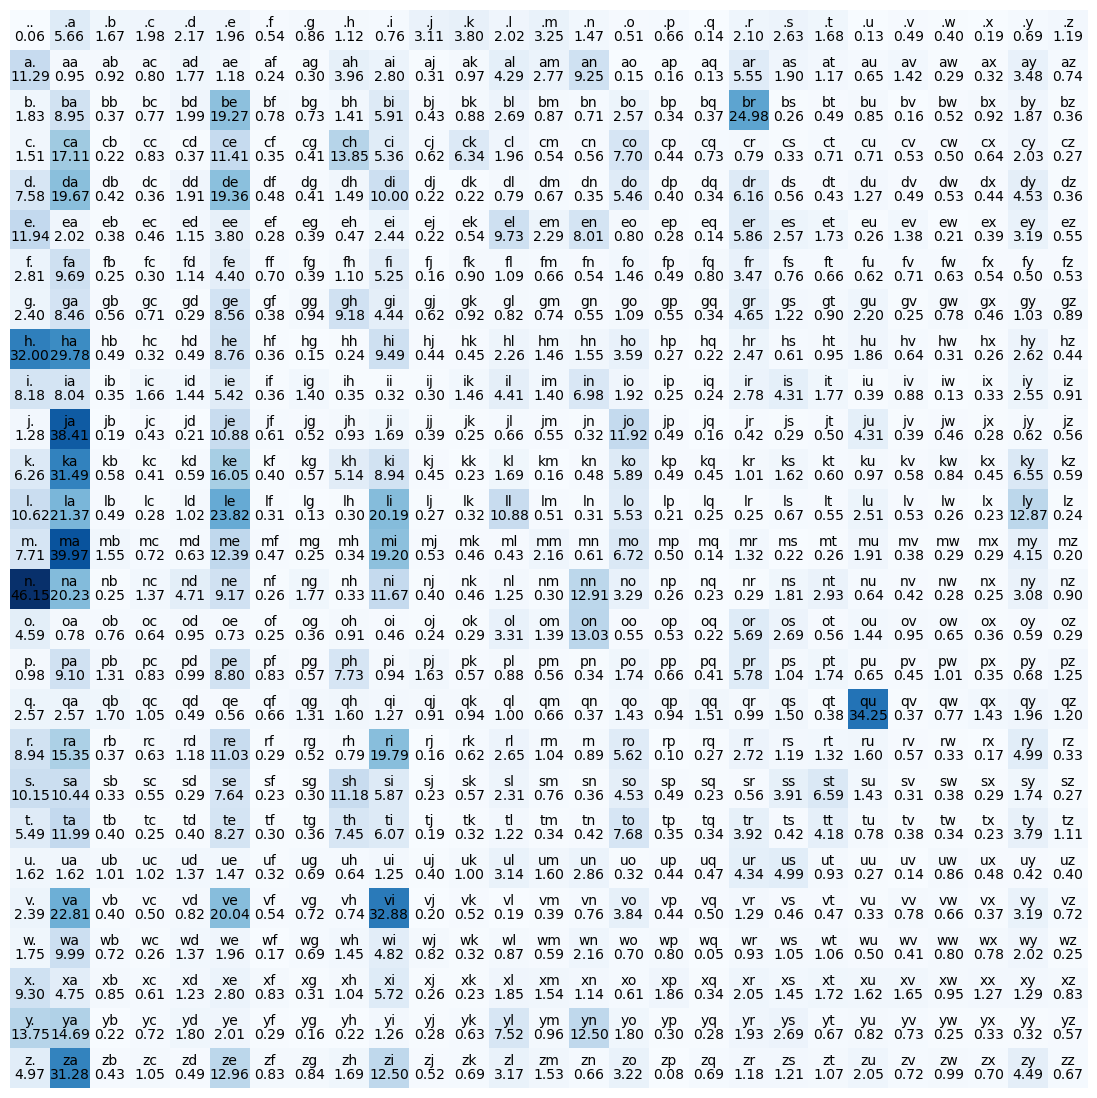

In [30]:
# extract the predicted counts from the network weights
N = W_reg.detach().exp()

plt.figure(figsize=(14, 14))
plt.imshow(N, cmap="Blues")
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = ix_to_char[i] + ix_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="black")
        plt.text(j, i, f"{N[i, j].item():.2f}", ha="center", va="top", color="black")
plt.axis("off");